In [4]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset
import torchvision.transforms as transforms

In [5]:
#hyperparameters
batch_size = 8
num_epochs = 100
learning_rate = 1e-4
L1_reg = 1e-6
L2_reg = 1e-4

#slope = 0.1

In [6]:
#data representation
transform= transforms.Compose([
        transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

transform_train = transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

transform_test = transforms.Compose([
        #transforms.Resize(256),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

In [7]:
#data loading & increasing dataset size
train_data1 = torchvision.datasets.Flowers102(root="./data",split = "test", transform=transform, download=True)
train_data2 = torchvision.datasets.Flowers102(root="./data",split = "test", transform=transform_train, download=True)
test_data = torchvision.datasets.Flowers102(root="./data",split = "train", transform=transform_test, download=True)

val_data1 = torchvision.datasets.Flowers102(root="./data",split = "val", transform=transform, download=True)
val_data2 = torchvision.datasets.Flowers102(root="./data",split = "val", transform=transform_train, download=True)
train_data = ConcatDataset([train_data1,train_data2, val_data1, val_data2])

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers = 4)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers = 4)

In [8]:
len(train_data), len(test_data)

(14338, 1020)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


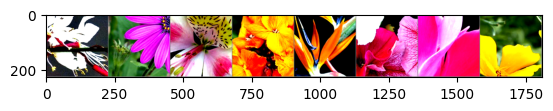

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter) 

# show images
imshow(torchvision.utils.make_grid(images))

In [10]:
# define network (including resnet18/50/101/152)
def conv3x3(in_channels, out_channels, stride=1, padding=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=padding, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.relu = nn.SiLU() #changed activation func to Swish(siLU)

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class Bottleneck(nn.Module):
    expansion = 4 

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.SiLU()
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.SiLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=0.5)#added dropout layer
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)#added dropout layer
        x = self.fc(x)

        return x

def resnet18(num_classes=102):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)
def resnet50(num_classes=102):
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes)
def resnet101(num_classes=102):
    return ResNet(Bottleneck, [3, 4, 23, 3], num_classes)
def resnet152(num_classes=102):
    return ResNet(Bottleneck, [3, 8, 36, 3], num_classes)

#choose resnet with desired depth
net = resnet50(num_classes=102)

print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): SiLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): SiLU()
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        

In [11]:
#set device
if torch.cuda.is_available():
    device = 'cuda:0'
    print("[INFO] Current device:", torch.cuda.get_device_name(torch.cuda.current_device()), f", device num:{torch.cuda.current_device()}")
elif torch.has_mps:
    device = 'mps'
    print("[INFO] Current device: MAC OS Metal Performance Shaders.")
else:
    device = 'cpu'
    print("[INFO] Current device: CPU")
    print("*"*50,"\n[WARNING] You may need to change the device to GPU or MPS to get better performance.")
    print("*"*50)
device = torch.device(device)

[INFO] Current device: NVIDIA GeForce RTX 3080 , device num:0


In [12]:
# consider class imbalance
from sklearn.utils.class_weight import compute_class_weight
def get_class_weights(train_data):
    labels = [label for _, label in train_data]
    #compute class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
    return torch.FloatTensor(class_weights).to(device)
class_weights = get_class_weights(train_data)

In [13]:
net.to(device)
#loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.NAdam(net.parameters(),lr=learning_rate, weight_decay=L2_reg)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

In [14]:
import mlflow
import mlflow.pytorch
import os
# define training & testing functions
def print_status(epoch, num_epoch, train_loss, test_acc):
    print(f"Epoch: {epoch}/{num_epoch}")
    print("Training Loss: {:.3f}\nTesting Acc: {:.2f}\n".format(train_loss, test_acc * 100))

def train_model(model, num_epochs, criterion, optimizer, name, log_dir="./logs_last"):
    accuracy_list = []
    
    # Start the MLflow run with nested run
    with mlflow.start_run(nested=True):  # Use the model name for the run
        # Log hyperparameters
        mlflow.log_param("learning_rate", learning_rate)
        mlflow.log_param("batch_size", batch_size)
        mlflow.log_param("L1_regularization", L1_reg)
        mlflow.log_param("L2_regularization", L2_reg)

        for epoch in range(num_epochs):
            epoch_loss = 0
            total_data = 0
            correct_answers = 0
            total_answers = 0
            
            # Training phase
            model.train()
            for inputs, labels in train_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Apply L1 regularization
                l1_norm = sum(p.abs().sum() for p in model.parameters())
                loss += L1_reg * l1_norm
                
                # Update epoch loss
                epoch_loss += loss.item() * len(labels)
                total_data += len(labels)
                
                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            # Average loss for the epoch
            epoch_loss /= total_data

            # Log training loss to MLflow
            mlflow.log_metric('Loss/train', epoch_loss, epoch)

            # Evaluation phase
            model.eval()
            for inputs, labels in test_dataloader:
                inputs = inputs.to(device)
                
                with torch.no_grad():
                    outputs = model(inputs)
                    predictions = torch.max(outputs, 1)[1].cpu()
                
                correct_answers += (labels == predictions).sum().item()
                total_answers += len(labels)
            
            # Calculate accuracy
            accuracy = correct_answers / total_answers
            accuracy_list.append(accuracy)
            
            # Log test accuracy to MLflow
            mlflow.log_metric('Accuracy/test', accuracy, epoch)
            
            # Save the model if the accuracy improves
            if max(accuracy_list) == accuracy:
                model_path = f"./models/{name}.pt"
                torch.save(model.state_dict(), model_path)
                mlflow.pytorch.log_model(model, "model")  # Log the model to MLflow

            # Print training status
            print_status(epoch + 1, num_epochs, epoch_loss, accuracy)
            
            # Step the scheduler
            scheduler.step()

        # Load the best model
        best_model_path = os.path.join("./models", f"{name}.pt")
        model.load_state_dict(torch.load(best_model_path))

    return model


In [15]:
import os 

os.makedirs("./models/", exist_ok = True)
model = train_model(net, num_epochs = num_epochs, criterion = criterion, optimizer = optimizer,
                       name = "best_model")

2024/09/26 22:03:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch: 1/100
Training Loss: 4.711
Testing Acc: 7.94



2024/09/26 22:05:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch: 2/100
Training Loss: 3.959
Testing Acc: 19.80



2024/09/26 22:06:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch: 3/100
Training Loss: 3.327
Testing Acc: 33.53



2024/09/26 22:07:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch: 4/100
Training Loss: 2.796
Testing Acc: 41.18



2024/09/26 22:08:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch: 5/100
Training Loss: 2.407
Testing Acc: 48.63



2024/09/26 22:10:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch: 6/100
Training Loss: 2.064
Testing Acc: 55.98



2024/09/26 22:11:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch: 7/100
Training Loss: 1.803
Testing Acc: 60.00



2024/09/26 22:12:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch: 8/100
Training Loss: 1.598
Testing Acc: 65.49



2024/09/26 22:13:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch: 9/100
Training Loss: 1.421
Testing Acc: 67.65



2024/09/26 22:15:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch: 10/100
Training Loss: 1.343
Testing Acc: 71.08

Epoch: 11/100
Training Loss: 1.320
Testing Acc: 70.59

Epoch: 12/100
Training Loss: 1.301
Testing Acc: 68.14

Epoch: 13/100
Training Loss: 1.309
Testing Acc: 70.69

Epoch: 14/100
Training Loss: 1.340
Testing Acc: 67.65

Epoch: 15/100
Training Loss: 1.386
Testing Acc: 68.82

Epoch: 16/100
Training Loss: 1.408
Testing Acc: 66.96

Epoch: 17/100
Training Loss: 1.429
Testing Acc: 67.94

Epoch: 18/100
Training Loss: 1.440
Testing Acc: 69.02

Epoch: 19/100
Training Loss: 1.397
Testing Acc: 67.94

Epoch: 20/100
Training Loss: 1.341
Testing Acc: 69.02

Epoch: 21/100
Training Loss: 1.260
Testing Acc: 69.71



2024/09/26 22:28:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch: 22/100
Training Loss: 1.185
Testing Acc: 73.24



2024/09/26 22:30:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch: 23/100
Training Loss: 1.091
Testing Acc: 74.61



2024/09/26 22:31:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch: 24/100
Training Loss: 0.970
Testing Acc: 75.88



2024/09/26 22:32:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch: 25/100
Training Loss: 0.848
Testing Acc: 82.45

Epoch: 26/100
Training Loss: 0.760
Testing Acc: 81.57



2024/09/26 22:35:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch: 27/100
Training Loss: 0.660
Testing Acc: 83.92



2024/09/26 22:36:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch: 28/100
Training Loss: 0.581
Testing Acc: 84.22



2024/09/26 22:37:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch: 29/100
Training Loss: 0.528
Testing Acc: 84.80



2024/09/26 22:38:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch: 30/100
Training Loss: 0.500
Testing Acc: 86.18



2024/09/26 22:40:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch: 31/100
Training Loss: 0.494
Testing Acc: 86.27

Epoch: 32/100
Training Loss: 0.496
Testing Acc: 85.59

Epoch: 33/100
Training Loss: 0.509
Testing Acc: 85.78

Epoch: 34/100
Training Loss: 0.537
Testing Acc: 85.00

Epoch: 35/100
Training Loss: 0.571
Testing Acc: 82.75

Epoch: 36/100
Training Loss: 0.639
Testing Acc: 81.86

Epoch: 37/100
Training Loss: 0.694
Testing Acc: 81.47

Epoch: 38/100
Training Loss: 0.753
Testing Acc: 80.39

Epoch: 39/100
Training Loss: 0.769
Testing Acc: 80.39

Epoch: 40/100
Training Loss: 0.786
Testing Acc: 79.61

Epoch: 41/100
Training Loss: 0.787
Testing Acc: 79.90

Epoch: 42/100
Training Loss: 0.737
Testing Acc: 79.61

Epoch: 43/100
Training Loss: 0.703
Testing Acc: 80.78

Epoch: 44/100
Training Loss: 0.636
Testing Acc: 82.35

Epoch: 45/100
Training Loss: 0.565
Testing Acc: 84.22

Epoch: 46/100
Training Loss: 0.506
Testing Acc: 84.31

Epoch: 47/100
Training Loss: 0.449
Testing Acc: 85.98



2024/09/26 22:59:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch: 48/100
Training Loss: 0.412
Testing Acc: 87.35



2024/09/26 23:00:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch: 49/100
Training Loss: 0.377
Testing Acc: 88.73

Epoch: 50/100
Training Loss: 0.363
Testing Acc: 88.33

Epoch: 51/100
Training Loss: 0.360
Testing Acc: 88.43

Epoch: 52/100
Training Loss: 0.360
Testing Acc: 88.53

Epoch: 53/100
Training Loss: 0.369
Testing Acc: 88.14

Epoch: 54/100
Training Loss: 0.383
Testing Acc: 88.63

Epoch: 55/100
Training Loss: 0.410
Testing Acc: 86.47

Epoch: 56/100
Training Loss: 0.463
Testing Acc: 83.53

Epoch: 57/100
Training Loss: 0.516
Testing Acc: 82.35

Epoch: 58/100
Training Loss: 0.552
Testing Acc: 82.65

Epoch: 59/100
Training Loss: 0.595
Testing Acc: 81.96

Epoch: 60/100
Training Loss: 0.595
Testing Acc: 83.73

Epoch: 61/100
Training Loss: 0.607
Testing Acc: 81.57

Epoch: 62/100
Training Loss: 0.577
Testing Acc: 81.27

Epoch: 63/100
Training Loss: 0.552
Testing Acc: 82.75

Epoch: 64/100
Training Loss: 0.505
Testing Acc: 85.00

Epoch: 65/100
Training Loss: 0.461
Testing Acc: 85.49

Epoch: 66/100
Training Loss: 0.417
Testing Acc: 85.49

Epoch: 67/

2024/09/26 23:23:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch: 68/100
Training Loss: 0.339
Testing Acc: 90.00

Epoch: 69/100
Training Loss: 0.314
Testing Acc: 89.51



2024/09/26 23:25:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch: 70/100
Training Loss: 0.304
Testing Acc: 90.20

Epoch: 71/100
Training Loss: 0.299
Testing Acc: 89.22

Epoch: 72/100
Training Loss: 0.300
Testing Acc: 89.41

Epoch: 73/100
Training Loss: 0.303
Testing Acc: 90.00

Epoch: 74/100
Training Loss: 0.309
Testing Acc: 88.43

Epoch: 75/100
Training Loss: 0.337
Testing Acc: 86.76

Epoch: 76/100
Training Loss: 0.380
Testing Acc: 85.88

Epoch: 77/100
Training Loss: 0.420
Testing Acc: 84.90

Epoch: 78/100
Training Loss: 0.451
Testing Acc: 85.69

Epoch: 79/100
Training Loss: 0.502
Testing Acc: 84.02

Epoch: 80/100
Training Loss: 0.496
Testing Acc: 84.22

Epoch: 81/100
Training Loss: 0.520
Testing Acc: 84.31

Epoch: 82/100
Training Loss: 0.475
Testing Acc: 86.18

Epoch: 83/100
Training Loss: 0.475
Testing Acc: 83.33

Epoch: 84/100
Training Loss: 0.439
Testing Acc: 88.33

Epoch: 85/100
Training Loss: 0.403
Testing Acc: 86.96

Epoch: 86/100
Training Loss: 0.351
Testing Acc: 87.35

Epoch: 87/100
Training Loss: 0.314
Testing Acc: 89.61

Epoch: 88/

2024/09/26 23:48:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch: 90/100
Training Loss: 0.261
Testing Acc: 90.49

Epoch: 91/100
Training Loss: 0.261
Testing Acc: 90.39

Epoch: 92/100
Training Loss: 0.259
Testing Acc: 90.20

Epoch: 93/100
Training Loss: 0.261
Testing Acc: 90.10

Epoch: 94/100
Training Loss: 0.270
Testing Acc: 89.61

Epoch: 95/100
Training Loss: 0.289
Testing Acc: 89.80

Epoch: 96/100
Training Loss: 0.325
Testing Acc: 88.43

Epoch: 97/100
Training Loss: 0.355
Testing Acc: 85.39

Epoch: 98/100
Training Loss: 0.396
Testing Acc: 86.57

Epoch: 99/100
Training Loss: 0.433
Testing Acc: 84.41

Epoch: 100/100
Training Loss: 0.437
Testing Acc: 86.18



/tmp/ipykernel_272425/1230645155.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


In [23]:
# load the best model
model.load_state_dict(torch.load(os.path.join("./models", f"best_model.pt")))

# hyperparameters
num_epochs = 20
learning_rate = 1e-4
L1_reg = 1e-7
L2_reg = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

/tmp/ipykernel_272425/1528912129.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join("./models", f"best_model.pt")))


In [24]:
# fine-tuning
os.makedirs("./models/model_ft", exist_ok = True)
best_model_ft = train_model(net, num_epochs = num_epochs, criterion = criterion, optimizer = optimizer,
                            name = "best_model_ft")

2024/09/27 01:19:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch: 1/20
Training Loss: 0.075
Testing Acc: 90.20



2024/09/27 01:20:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch: 2/20
Training Loss: 0.071
Testing Acc: 91.18

Epoch: 3/20
Training Loss: 0.071
Testing Acc: 90.49

Epoch: 4/20
Training Loss: 0.070
Testing Acc: 90.00

Epoch: 5/20
Training Loss: 0.069
Testing Acc: 90.29

Epoch: 6/20
Training Loss: 0.065
Testing Acc: 90.39

Epoch: 7/20
Training Loss: 0.071
Testing Acc: 90.39

Epoch: 8/20
Training Loss: 0.067
Testing Acc: 90.39

Epoch: 9/20
Training Loss: 0.064
Testing Acc: 90.69

Epoch: 10/20
Training Loss: 0.066
Testing Acc: 90.59

Epoch: 11/20
Training Loss: 0.061
Testing Acc: 90.49

Epoch: 12/20
Training Loss: 0.063
Testing Acc: 90.10

Epoch: 13/20
Training Loss: 0.061
Testing Acc: 90.39

Epoch: 14/20
Training Loss: 0.065
Testing Acc: 90.10

Epoch: 15/20
Training Loss: 0.062
Testing Acc: 90.59

Epoch: 16/20
Training Loss: 0.059
Testing Acc: 90.69

Epoch: 17/20
Training Loss: 0.064
Testing Acc: 90.69

Epoch: 18/20
Training Loss: 0.058
Testing Acc: 90.29

Epoch: 19/20
Training Loss: 0.063
Testing Acc: 90.49

Epoch: 20/20
Training Loss: 0.060
Te

/tmp/ipykernel_272425/1230645155.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


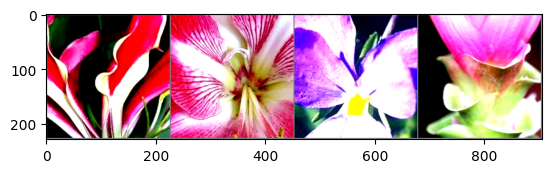

GroundTruth:     20    90    51    38


In [18]:
# test the model on test data
dataiter = iter(test_dataloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth: ', ' '.join('%5s' % labels[j].item() for j in range(4)))

In [26]:
# initialize
num_classes = 102
correct_per_class = [0] * num_classes
total_per_class = [0] * num_classes

model.eval()

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1) 
       
        for label, prediction in zip(labels, predicted):
            total_per_class[label] += 1
            if label == prediction:
                correct_per_class[label] += 1


accuracy_per_class = [0] * num_classes
for i in range(num_classes):
    if total_per_class[i] > 0:
        accuracy_per_class[i] = correct_per_class[i] / total_per_class[i] * 100

# print the accuracy per class
for i in range(num_classes):
    print(f"Class {i} Accuracy: {accuracy_per_class[i]:.2f}%")

Class 0 Accuracy: 90.00%
Class 1 Accuracy: 100.00%
Class 2 Accuracy: 50.00%
Class 3 Accuracy: 70.00%
Class 4 Accuracy: 90.00%
Class 5 Accuracy: 100.00%
Class 6 Accuracy: 80.00%
Class 7 Accuracy: 90.00%
Class 8 Accuracy: 90.00%
Class 9 Accuracy: 100.00%
Class 10 Accuracy: 100.00%
Class 11 Accuracy: 80.00%
Class 12 Accuracy: 80.00%
Class 13 Accuracy: 100.00%
Class 14 Accuracy: 90.00%
Class 15 Accuracy: 80.00%
Class 16 Accuracy: 100.00%
Class 17 Accuracy: 90.00%
Class 18 Accuracy: 90.00%
Class 19 Accuracy: 100.00%
Class 20 Accuracy: 100.00%
Class 21 Accuracy: 100.00%
Class 22 Accuracy: 100.00%
Class 23 Accuracy: 100.00%
Class 24 Accuracy: 100.00%
Class 25 Accuracy: 100.00%
Class 26 Accuracy: 100.00%
Class 27 Accuracy: 80.00%
Class 28 Accuracy: 100.00%
Class 29 Accuracy: 80.00%
Class 30 Accuracy: 50.00%
Class 31 Accuracy: 60.00%
Class 32 Accuracy: 80.00%
Class 33 Accuracy: 100.00%
Class 34 Accuracy: 100.00%
Class 35 Accuracy: 90.00%
Class 36 Accuracy: 100.00%
Class 37 Accuracy: 90.00%
Clas

In [25]:
from sklearn.metrics import classification_report

all_labels = []
all_preds = []

model.eval()

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        # predict
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        # append to lists
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())


print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.91      1.00      0.95        10
           2       0.71      0.50      0.59        10
           3       0.88      0.70      0.78        10
           4       1.00      0.90      0.95        10
           5       0.91      1.00      0.95        10
           6       1.00      0.80      0.89        10
           7       0.90      0.90      0.90        10
           8       0.90      0.90      0.90        10
           9       1.00      1.00      1.00        10
          10       0.83      1.00      0.91        10
          11       1.00      0.80      0.89        10
          12       1.00      0.80      0.89        10
          13       0.91      1.00      0.95        10
          14       1.00      0.90      0.95        10
          15       0.89      0.80      0.84        10
          16       1.00      1.00      1.00        10
          17       1.00    